## Introduction

In this notebook, we'll build up a practical understanding of how neural networks are constructed and trained in PyTorch, using PyTorch's `optim` module to implement gradient descent and update the model parameters.

```mermaid
flowchart LR
    X[Input] --> M[Model]
    M --> P[Prediction]
    P --> L[Loss]
    Y[Target] --> L
    L --> G[Gradients]
    G --> U[Update]
    U --> M
```


We'll start with simple linear layers, inspect their parameters directly, and observe how predictions change as those parameters change. From there, we'll walk through the full training process—forward pass, loss computation, gradient calculation, and parameter updates.  We'll first use PyTorch's built-in tools, and at the end will re-implement Mean Squared Error and standard gradient descent ourselves. 



The goal is not just to train models that work, but to develop a clear mental model of why they work and what PyTorch is actually doing at each step.

## Setup

### Import Libraries

In [1]:
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torchinfo

---

## Section 1: How to Build a Neural Network Model

A neural network model consists of layers that transform input data into output predictions. The simplest layer is a linear layer, which multiplies inputs by weights and adds a bias - exactly what you did manually in the previous session. PyTorch's `nn.Linear` creates these layers for you, and `nn.Sequential` lets you stack multiple layers together to build deeper networks.

| Code | Description |
| :-- | :-- |
| `nn.Linear(n_features_in, n_features_out)` | Creates a linear model that takes in `n_features_in` input features (nodes) and<br>outputs `n_features_out` features (nodes).|
| `nn.Sequential(`<br>&nbsp;&nbsp;&nbsp;&nbsp;`nn.Linear(1,10),`<br>&nbsp;&nbsp;&nbsp;&nbsp;`nn.Linear(10,1)`<br>`)` | Creates a container where multiple layers are stacked in a sequential order. This ensures that input is passed through the network in that order during the forward pass. This model has one input feature, one output feature, and one hidden layer with 10 nodes. |
| `model = nn.Sequential(`<br>&nbsp;&nbsp;&nbsp;&nbsp;`nn.Linear(2,20),`<br>&nbsp;&nbsp;&nbsp;&nbsp;`nn.Linear(20,10),`<br>&nbsp;&nbsp;&nbsp;&nbsp;`nn.Linear(10,1)`<br>`)` | Assigns the container to a variable `model`. This model has 2 input nodes, two hidden<br>layers with 20 and 10 nodes, respectively, and one output node. |

**Example**: Create the model illustrated below, which has 3 input features and 2 output features:

```mermaid
flowchart LR
  %% Layers
  subgraph IN["Input Layer"]
    direction TB
    i1(( ))
    i2(( ))
    i3(( ))
  end

  subgraph OUT["Output Layer"]
    direction TB
    o1(( ))
    o2(( ))
  end

  %% Dense connections: Input -> Hidden
  i1 --> o1
  i2 --> o1
  i3 --> o1

  i1 --> o2
  i2 --> o2
  i3 --> o2

  %% Styling
  classDef input fill:#F4A261,stroke:#333,stroke-width:1px;
  classDef hidden fill:#2ECC71,stroke:#333,stroke-width:1px;
  classDef output fill:#4D7CFE,stroke:#333,stroke-width:1px;

  class i1,i2,i3 input;
  class o1,o2 output;

```

In [2]:
model = nn.Linear(3, 2)
model

Linear(in_features=3, out_features=2, bias=True)

Make sure data passes successfully through the model, and the output has the right shape. The last number inside `torch.Size` should correspond to the number of output features in the model.

In [3]:
data = torch.randn(100, 3)
model(data).shape

torch.Size([100, 2])

How many total parameters need to be trained in this model? (`torchinfo.summary(model)`):

In [4]:
torchinfo.summary(model)

Layer (type:depth-idx)                   Param #
Linear                                   8
Total params: 8
Trainable params: 8
Non-trainable params: 0

**Exercise**: Create the model illustrated below, which has 4 input features and 1 output features:

```mermaid
flowchart LR
  %% Layers
  subgraph IN["Input Layer"]
    direction TB
    i1(( ))
    i2(( ))
    i3(( ))
    i4(( ))
  end

  subgraph OUT["Output Layer"]
    direction TB
    o1(( ))
  end

  %% Dense connections: Input -> Hidden
  i1 --> o1
  i2 --> o1
  i3 --> o1
  i4 --> o1

  %% Styling
  classDef input fill:#F4A261,stroke:#333,stroke-width:1px;
  classDef hidden fill:#2ECC71,stroke:#333,stroke-width:1px;
  classDef output fill:#4D7CFE,stroke:#333,stroke-width:1px;

  class i1,i2,i3,i4 input;
  class o1 output;

```


In [5]:
model = nn.Linear(4,1)
model

Linear(in_features=4, out_features=1, bias=True)

Make sure data passes successfully through the model, and that the output has the right shape. The last number inside `torch.Size` should correspond to the number of output features in the model.

In [6]:
data = torch.randn(100, 4)
model(data).shape

torch.Size([100, 1])

How many total parameters need to be trained in this model? (`torchinfo.summary(model)`):

In [7]:
torchinfo.summary(model)

Layer (type:depth-idx)                   Param #
Linear                                   5
Total params: 5
Trainable params: 5
Non-trainable params: 0

 **Exercise**: Create the model illustrated below, which has 3 input features, 2 hidden features and 2 output features (Note: Use `nn.Sequential()`):

```mermaid
flowchart LR
  %% Layers
  subgraph IN["Input Layer"]
    direction TB
    i1(( ))
    i2(( ))
    i3(( ))
  end

  subgraph HID["Hidden Layer"]
    direction TB
    h1(( ))
    h2(( ))
  end

  subgraph OUT["Output Layer"]
    direction TB
    o1(( ))
    o2(( ))
  end

  %% Dense connections: Input -> Hidden
  i1 --> h1
  i2 --> h1
  i3 --> h1
  
  i1 --> h2
  i2 --> h2
  i3 --> h2

  h1 --> o1
  h2 --> o1

  h1 --> o2
  h2 --> o2
  

  %% Styling
  classDef input fill:#F4A261,stroke:#333,stroke-width:1px;
  classDef hidden fill:#2ECC71,stroke:#333,stroke-width:1px;
  classDef output fill:#4D7CFE,stroke:#333,stroke-width:1px;

  class i1,i2,i3 input;
  class h1,h2 hidden;
  class o1,o2 output;

```

In [8]:
model = nn.Sequential(nn.Linear(3, 2), nn.Linear(2, 2))
model

Sequential(
  (0): Linear(in_features=3, out_features=2, bias=True)
  (1): Linear(in_features=2, out_features=2, bias=True)
)

Make sure data passes successfully through the model, and the output has the right shape. The last number inside `torch.Size` should correspond to the number of output features in the model.

In [9]:
data = torch.randn(100, 3)
model(data).shape

torch.Size([100, 2])

How many total parameters need to be trained in this model? (`torchinfo.summary(model)`):

In [10]:
torchinfo.summary(model)

Layer (type:depth-idx)                   Param #
Sequential                               --
├─Linear: 1-1                            8
├─Linear: 1-2                            6
Total params: 14
Trainable params: 14
Non-trainable params: 0

 **Exercise**: As the number of nodes increases, the style of visualization changes to more of a summary.  Create the model illustrated below, which has 8 input features, 20 hidden features and 1 output feature (Note: Use `nn.Sequential()`):

```mermaid
flowchart LR
  x["Input\n(batch, 8)"]
  l1["Linear\nin=8 → out=20"]
  l2["Linear\nin=20 → out=1"]
  y["Output\n(batch, 1)"]

  x --> l1 --> l2 --> y

```

In [11]:
model = nn.Sequential(nn.Linear(8, 20), nn.Linear(20, 1))
model

Sequential(
  (0): Linear(in_features=8, out_features=20, bias=True)
  (1): Linear(in_features=20, out_features=1, bias=True)
)

Make sure data passes successfully through the model, and the output has the right shape:

In [12]:
data = torch.randn(100, 8)
model(data).shape

torch.Size([100, 1])

How many total parameters need to be trained in this model? (`torchinfo.summary(model)`):

In [13]:
torchinfo.summary(model)

Layer (type:depth-idx)                   Param #
Sequential                               --
├─Linear: 1-1                            180
├─Linear: 1-2                            21
Total params: 201
Trainable params: 201
Non-trainable params: 0

 **Exercise**: Create the model illustrated below:

```mermaid
flowchart LR
  x["Input\n(batch, 20)"]
  l1["Linear\nin=20 → out=50"]
  l2["Linear\nin=50 → out=35"]
  l3["Linear\nin=35 → out=10"]
  l4["Linear\nin=10 → out=1"]
  y["Output\n(batch, 1)"]

  x --> l1 --> l2 --> l3 --> l4 --> y

```

In [14]:
model = nn.Sequential(
    nn.Linear(20, 50), 
    nn.Linear(50, 35),
    nn.Linear(35, 10),
    nn.Linear(10, 1),
)
model

Sequential(
  (0): Linear(in_features=20, out_features=50, bias=True)
  (1): Linear(in_features=50, out_features=35, bias=True)
  (2): Linear(in_features=35, out_features=10, bias=True)
  (3): Linear(in_features=10, out_features=1, bias=True)
)

Make sure data passes successfully through the model, and the output has the right shape:

In [15]:
data = torch.randn(100, 20)
model(data).shape

torch.Size([100, 1])

How many total parameters need to be trained in this model? (`torchinfo.summary(model)`):

In [16]:
torchinfo.summary(model)

Layer (type:depth-idx)                   Param #
Sequential                               --
├─Linear: 1-1                            1,050
├─Linear: 1-2                            1,785
├─Linear: 1-3                            360
├─Linear: 1-4                            11
Total params: 3,206
Trainable params: 3,206
Non-trainable params: 0

---

## Section 2: Initialize and Extract Model Parameters

Each of these model parameters (i.e. the weights and biases of each layer) are stored in Pytorch as a `tensor()`.  
When creating the model, PyTorch starts out with random values for each parameter, and then these values are updated during learning in order to better-fit the data.

In this section, we'll explore the parameters directly and manually update them ourselves, to see how they influence the model's prediction.

| Code | Description |
| :-- | :-- |
| `list(model.parameters())` | Get a list of the tensors in the model. |
| `list(model.named_parameters())` | Get a dict of the tensors in the model and their names. |
| `model.state_dict()` | Yet another way to see the model parameters. |
| `model[0].weight` | Get the "weight" tensor from the first layer (index 0) |
| `model[0].bias` | Get the "bias" tensor from the first layer (index 0) |
| `model[1].weight` | Get the "weight" tensor from the second layer (index 1)|
| `model[1].bias` | Get the "bias" tensor from the second layer (index 1)|
| `with torch.no_grad():`<br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;`model[1].weight[:] = torch.tensor([1, 2, 3])` | Override the automatically generated random parameter values in the second layer.  |

### Exercises

**Example**: Create the following model and view the randomly-initialized values of all parameters in the model.


```mermaid
flowchart LR
  x["Input\n(batch, 3)"]
  l1["Linear\nin=3 → out=2"]
  l2["Linear\nin=2 → out=1"]
  y["Output\n(batch, 1)"]

  x --> l1 --> l2 --> y

```

In [35]:
torch.manual_seed(42)
model = nn.Sequential(nn.Linear(3, 2), nn.Linear(2, 1))
list(model.named_parameters())

[('0.weight',
  Parameter containing:
  tensor([[ 0.4414,  0.4792, -0.1353],
          [ 0.5304, -0.1265,  0.1165]], requires_grad=True)),
 ('0.bias',
  Parameter containing:
  tensor([-0.2811,  0.3391], requires_grad=True)),
 ('1.weight',
  Parameter containing:
  tensor([[ 0.6233, -0.5188]], requires_grad=True)),
 ('1.bias',
  Parameter containing:
  tensor([0.6146], requires_grad=True))]

Generate a sample of random data and calculate the model's output with those parameter values:

In [36]:
torch.manual_seed(42)     # Set the randomizer to a specific value
data = torch.randn(1, 3)  # Generate 1 sample of data with 3 features (a 1x3 tensor)
model(data)

tensor([[0.2765]], grad_fn=<AddmmBackward0>)

Set the bias of the output layer (layer "1") to **100**, and run the same data through the model. How does it change the output?

In [37]:
with torch.no_grad(): 
    model[1].bias[:] = torch.tensor([100])

model[1].bias

Parameter containing:
tensor([100.], requires_grad=True)

In [38]:
output = model(data)
output

tensor([[99.6619]], grad_fn=<AddmmBackward0>)

**Exercise**: Create the following model and view the randomly-initialized values of all parameters in the model.


```mermaid
flowchart LR
  x["Input\n(batch, 1)"]
  l1["Linear\nin=1 → out=1"]
  l2["Linear\nin=1 → out=1"]
  y["Output\n(batch, 1)"]

  x --> l1 --> l2 --> y

```

In [45]:
torch.manual_seed(42)
model = nn.Sequential(nn.Linear(1, 1), nn.Linear(1, 1))
list(model.named_parameters())

[('0.weight',
  Parameter containing:
  tensor([[0.7645]], requires_grad=True)),
 ('0.bias',
  Parameter containing:
  tensor([0.8300], requires_grad=True)),
 ('1.weight',
  Parameter containing:
  tensor([[-0.2343]], requires_grad=True)),
 ('1.bias',
  Parameter containing:
  tensor([0.9186], requires_grad=True))]

Generate a sample of random data and calculate the model's output with those parameter values:

In [46]:
torch.manual_seed(42)     # Set the randomizer to a specific value
data = torch.randn(1, 1)  # Generate 1 sample of data with 1 feature (a 1x1 tensor)
output = model(data)
output

tensor([[0.6639]], grad_fn=<AddmmBackward0>)

Set the weights on the input layer (layer "0") to **-10**, and run the same data through the model. How does it change the output?

In [47]:
with torch.no_grad(): 
    model[0].weight[:] = torch.tensor([-10])

model[0].weight

Parameter containing:
tensor([[-10.]], requires_grad=True)

In [48]:
output = model(data)
output

tensor([[1.5129]], grad_fn=<AddmmBackward0>)

**Exercise**: Create the following model and view the randomly-initialized values of all parameters in the model.


```mermaid
flowchart LR
  x["Input\n(batch, 100)"]
  l1["Linear\nin=100 → out=50"]
  l2["Linear\nin=50 → out=1"]
  l3["Linear\nin=1 → out=1"]
  y["Output\n(batch, 1)"]

  x --> l1 --> l2 --> l3 --> y

```

In [23]:
model = nn.Sequential(nn.Linear(100, 50), nn.Linear(50, 1), nn.Linear(1, 1))
list(model.named_parameters())

[('0.weight',
  Parameter containing:
  tensor([[-0.0219,  0.0202, -0.0487,  ...,  0.0250, -0.0132, -0.0726],
          [ 0.0023, -0.0683, -0.0848,  ..., -0.0369,  0.0842,  0.0390],
          [-0.0050, -0.0603, -0.0612,  ..., -0.0212, -0.0344, -0.0479],
          ...,
          [ 0.0638,  0.0013,  0.0334,  ...,  0.0568, -0.0284,  0.0361],
          [ 0.0730,  0.0146,  0.0343,  ..., -0.0661, -0.0194,  0.0313],
          [ 0.0547, -0.0048,  0.0806,  ..., -0.0716,  0.0438, -0.0200]],
         requires_grad=True)),
 ('0.bias',
  Parameter containing:
  tensor([ 0.0647, -0.0026,  0.0496,  0.0959, -0.0357, -0.0985,  0.0943, -0.0551,
           0.0229,  0.0622, -0.0155,  0.0782,  0.0648, -0.0201,  0.0262,  0.0076,
           0.0978,  0.0692, -0.0666,  0.0096,  0.0539,  0.0765,  0.0341,  0.0425,
          -0.0185,  0.0022, -0.0692,  0.0823,  0.0787, -0.0551, -0.0856,  0.0780,
          -0.0886,  0.0641, -0.0974, -0.0511, -0.0423,  0.0940, -0.0169,  0.0863,
           0.0291,  0.0969,  0.0662, 

Generate a sample of random data and calculate the model's output with those parameter values:

In [ ]:
torch.manual_seed(42)     # Set the randomizer to a specific value
data = torch.randn(1, 100)  # Generate 1 sample of data with 100 features (a 1x100 tensor)
model(data)

Set **both** the bias and the weights of the output layer (layer "2") to **0**, and run the same data through the model. How does it change the output?

In [25]:
with torch.no_grad(): 
    model[2].weight[:] = torch.tensor([0])
    model[2].bias[:] = torch.tensor([0])

model(data)

tensor([[0.]], grad_fn=<AddmmBackward0>)

---

## Section 3: Training Our Model: Iteratively Optimizing Model Parameters to Minimize Loss



Training models requires:
  1. A "forward" pass: The model make a prediction, and the loss is calculated.
  2. A "backward" pass: Loss gradients are calculated for model parameters, and the parameter values are updated.
  3. Iteration: Training is repeated some number of times.
  4. Learning tracking: The training process is recorded for troubleshooting.


Below is the model training function we'll use for doing each training iteration: `update_model()`:

In [49]:
def update_model(model, loss_function, optimizer, x, y_obs) -> float:
    """
    Do one training iteration, and return its loss.
    
    Arguments:
      - model: the PyTorch model we'll be training (e.g. `nn.Sequential(Linear(1, 1)))`)
      - loss_function: the loss function we'll use to estimate model fit, by calculating loss (e.g. `nn.MSELoss()`)
      - optimizer: a PyTorch "Optimizer" object that decides how much to update each parameter. (e.g. `optim.SGD()`)
      - x: The `x` input data used for training
      - y_obs: The expected result data used for training. (used here for "supervised" training.)    
    """

    # Forward Pass
    optimizer.zero_grad()                  # Reset parameter gradients
    y_pred = model(x)                      # Make a Prediction
    loss = loss_function(y_pred, y_obs)    # Calculate the overall prediction error ("Loss")

    # Backward Pass
    loss.backward()   # Calculate the loss gradients and store them in each parameters' ".grad" attribute
    optimizer.step()  # Update the model's parameters, based on their stored gradients

    # record the loss, for plotting or logging
    return loss.item()  
    



We'll monitor the quality of training by plotting:
  1. `plot_losses()`: The loss value over time shows how quickly training is improving.
  2. `plot_1d_model_fit()`: Makes a scatter plot with regression line, to show the model's fit.

In [50]:

def plot_losses(losses, ax=None) -> None:
    """Plot the losses over each training iteration."""
    if ax is None:
        ax = plt.gca()
    ax.plot(losses, ':.')
    ax.set(
        title='Loss Over Learning Iterations',
        xlabel='Iteration #',
        ylabel='Loss',
    )
    

def plot_1d_model_fit(model, x, y_obs, ax=None) -> None:
    """Plot a scatterplot and regression line to show model fit"""
    if ax is None:
        ax = plt.gca()

    # Make a scatterplot of the data points (x vs y_obs)
    ax.plot(x, y_obs, '.', markersize=1.5);

    # Plot a regression line
    x_range = torch.linspace(x.min(), x.max(), 100)  # Get a sequence of x values
    y_pred = model(x_range.reshape(-1, 1))
    ax.plot(x_range, y_pred.detach().numpy(), ':', linewidth=2)
    ax.set(title='Model Fit', xlabel='X', ylabel='Y')


### Exercises

There are so many things to choose: How does the learning rate, optimizer, model architecture and complexity, and even the number of learning iterations itself affect learning?  Let's get a sense of each of these parameters' behaviors.  

In each of the following exercises, experiment with the requested single parameter of the model and training, in order to improve training performance.  (Hint: There's an `UPDATE ME` comment next to the key line to update.)

**Exercise**: How many training iterations are needed to train this model? Update the `num_iterations` variable just until the model has been fit. When the loss curve starts to flatten, the model is as fit as well as it can be.

{'0.weight': tensor([[4.8087]]), '0.bias': tensor([2.2150])}

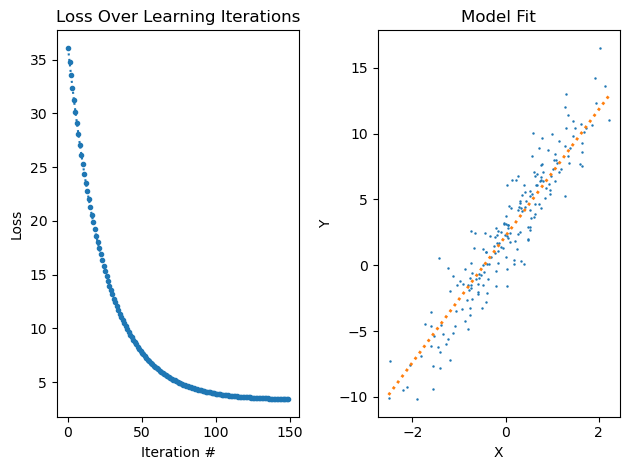

In [54]:
# Generate some Data
torch.manual_seed(42)
x = torch.randn(200, 1)
y_obs = (5 * x + 2) + 2 * torch.randn(200, 1)  # True Model: 5x + 2
y_obs[:20]

# Set up the model and training hyperparameters
model = nn.Sequential(nn.Linear(1, 1))
loss_function = nn.MSELoss()
optimizer = optim.SGD(params=model.parameters(), lr=.01)
num_iterations = 150   # UPDATE ME!

# Train the Model
losses = [update_model(model, loss_function, optimizer, x, y_obs) for _ in range(num_iterations)]

# Make a Figure showing the losses and model fit
plt.subplot(1, 2, 1); plot_losses(losses);
plt.subplot(1, 2, 2); plot_1d_model_fit(model, x, y_obs);
plt.tight_layout();
dict(model.state_dict())

{'0.weight': tensor([[4.8087]]), '0.bias': tensor([2.2150])}

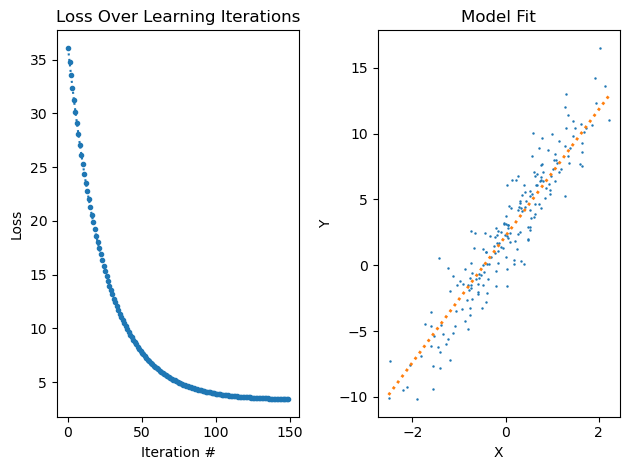

In [29]:
# Generate some Data
torch.manual_seed(42)
x = torch.randn(200, 1)
y_obs = (5 * x + 2) + 2 * torch.randn(200, 1)  # True Model: 5x + 2
y_obs[:20]

# Set up the model and training hyperparameters
model = nn.Sequential(nn.Linear(1, 1))
loss_function = nn.MSELoss()
optimizer = optim.SGD(params=model.parameters(), lr=.01)
num_iterations = 150   # UPDATE ME!

# Train the Model
losses = [update_model(model, loss_function, optimizer, x, y_obs) for _ in range(num_iterations)]

# Make a Figure showing the losses and model fit
plt.subplot(1, 2, 1); plot_losses(losses);
plt.subplot(1, 2, 2); plot_1d_model_fit(model, x, y_obs);
plt.tight_layout();
dict(model.state_dict())

**Exercise**: Does the number of layers affect training speed?  Add a hidden layer to the `model` below and see if it improves or worsens model training.

{'weight': tensor([[4.8087]]), 'bias': tensor([2.2150])}

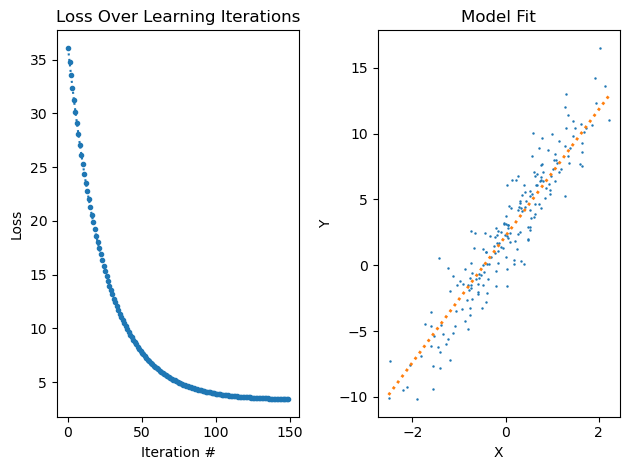

In [56]:
# Generate some Data
torch.manual_seed(42)
x = torch.randn(200, 1)
y_obs = (5 * x + 2) + 2 * torch.randn(200, 1)  # True Model: 5x + 2
y_obs[:20]

# Set up the model and training hyperparameters
model = nn.Linear(1, 1)   # UPDATE ME!
loss_function = nn.MSELoss()
optimizer = optim.SGD(params=model.parameters(), lr=.01)
num_iterations = 150   # UPDATE ME!

# Train the Model
losses = [update_model(model, loss_function, optimizer, x, y_obs) for _ in range(num_iterations)]

# Make a Figure showing the losses and model fit
plt.subplot(1, 2, 1); plot_losses(losses);
plt.subplot(1, 2, 2); plot_1d_model_fit(model, x, y_obs);
plt.tight_layout();
dict(model.state_dict())

{'weight': tensor([[5.0821]]), 'bias': tensor([2.2584])}

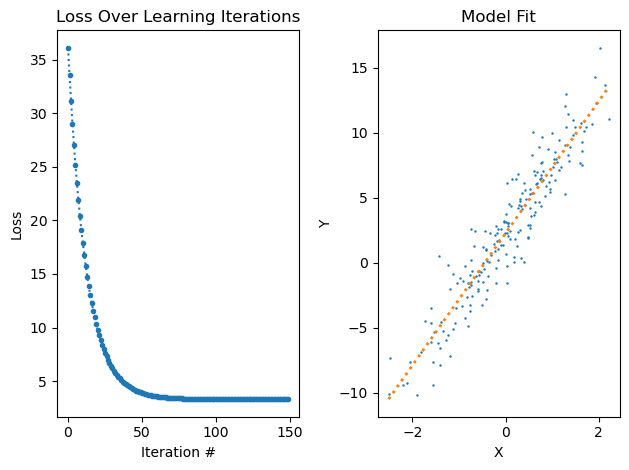

In [ ]:
# Generate some Data
torch.manual_seed(42)
x = torch.randn(200, 1)
y_obs = (5 * x + 2) + 2 * torch.randn(200, 1)  # True Model: 5x + 2
y_obs[:20]

# Set up the model and training hyperparameters
model = nn.Sequential(nn.Linear(1, 2), nn.Linear(2, 1))  
loss_function = nn.MSELoss()
optimizer = optim.SGD(params=model.parameters(), lr=.01)
num_iterations = 150   # UPDATE ME!

# Train the Model
losses = [update_model(model, loss_function, optimizer, x, y_obs) for _ in range(num_iterations)]

# Make a Figure showing the losses and model fit
plt.subplot(1, 2, 1); plot_losses(losses);
plt.subplot(1, 2, 2); plot_1d_model_fit(model, x, y_obs);
plt.tight_layout();
dict(model.state_dict())

**Exercise**: The `optimizer` is responsible for making a decision on how to update the parameters.  It can take into account the parameter values themselves, their gradients, the parameters' training history, and supplied "hyperparameters" like the learning rate.  

In this exercise, we're using the `SGD()` optimizer (i.e. Gradient Descent).  It takes a `lr` (learning rate) parameter to decide how much to update the parameters. 

Experiment: For this dataset and model, how high can we make the learning rate (`lr`), before the model stops learning productively? In other words, from (approximately) which learning rate does the loss increase instead of decrease?

{'0.weight': tensor([[-8016619.]]), '0.bias': tensor([-11931332.])}

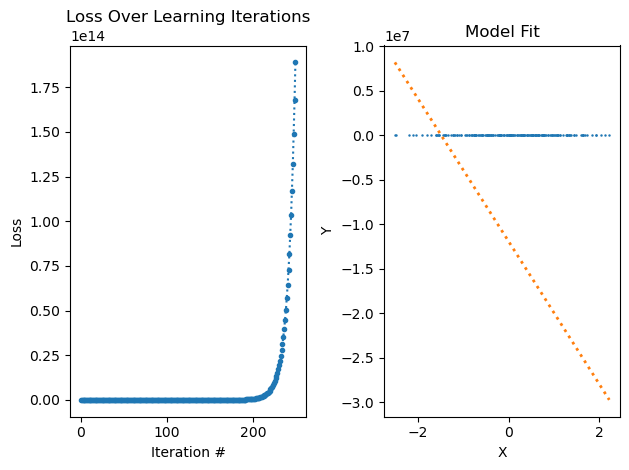

In [61]:
# Generate some Data
torch.manual_seed(42)
x = torch.randn(200, 1)
y_obs = (5 * x + 2) + 2 * torch.randn(200, 1)  # True Model: 5x + 2
y_obs[:20]

# Set up the model and training hyperparameters
model = nn.Sequential(nn.Linear(1, 1))
loss_function = nn.MSELoss()
optimizer = optim.SGD(params=model.parameters(), lr=1)  # UPDATE ME (just the "lr" value)!
num_iterations = 250   

# Train the Model
losses = [update_model(model, loss_function, optimizer, x, y_obs) for _ in range(num_iterations)]

# Make a Figure showing the losses and model fit
plt.subplot(1, 2, 1); plot_losses(losses);
plt.subplot(1, 2, 2); plot_1d_model_fit(model, x, y_obs);
plt.tight_layout();
dict(model.state_dict())

{'0.weight': tensor([[5.0967]]), '0.bias': tensor([2.2584])}

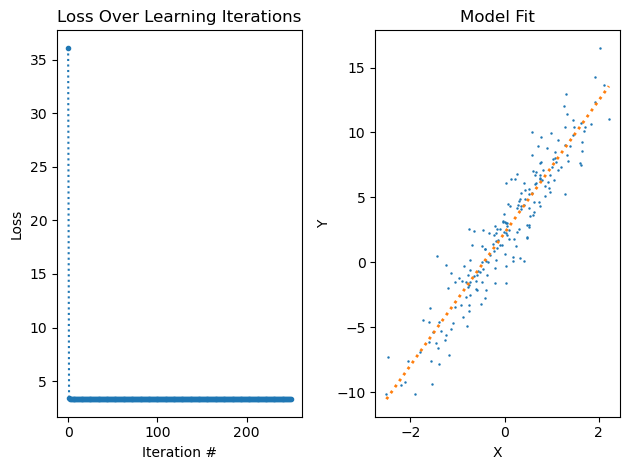

In [33]:
# Generate some Data
torch.manual_seed(42)
x = torch.randn(200, 1)
y_obs = (5 * x + 2) + 2 * torch.randn(200, 1)  # True Model: 5x + 2
y_obs[:20]

# Set up the model and training hyperparameters
model = nn.Sequential(nn.Linear(1, 1))
loss_function = nn.MSELoss()
optimizer = optim.SGD(params=model.parameters(), lr=0.5)  # UPDATE ME (just the "lr" value)!
num_iterations = 250   

# Train the Model
losses = [update_model(model, loss_function, optimizer, x, y_obs) for _ in range(num_iterations)]

# Make a Figure showing the losses and model fit
plt.subplot(1, 2, 1); plot_losses(losses);
plt.subplot(1, 2, 2); plot_1d_model_fit(model, x, y_obs);
plt.tight_layout();
dict(model.state_dict())

**Exercise**: Why pick a learning rate ourselves at all?  Pytorch supplies a number of "adaptive" optimizers, that tweak the learning rate based on a number of self-measuring factors.  These adaptive optimizers tend to be more robust than the standard gradient descent (SGD) optimizer.

| Complexity | Code | Description |
| :-- | :-- | :-- |
| Lowest | `torch.optim.SGD(model.parameters(), lr=0.01)` | a gradient descent (GD) optimizer with a *fixed* learning rate `lr` of 0.01 |
| Low | `torch.optim.Adagrad(model.parameters(), lr=.01)` | an adaptive gradient optimizer, with an *initialized* learning rate of 0.01.|
| High | `torch.optim.RMSprop(model.parameters(), lr=.01)` | a root mean square (RMS) propagation optimizer, with an *initialized* learning rate of 0.01. It's Adagrad with a moving average. |
| Highest | `torch.optim.Adam(model.parameters(), lr=.01)` | an adaptive moment optimizer, with an *initialized* learning rate of 0.01. It's RMSprop with momentum. |

*Experiment*: The learning rate has been set too high, and the model is not converging properly.  Instead of adjusting the learning rate, exchange the optimizer itself with a more robust one. See if it's able to adjust and recover convergence. 

{'0.weight': tensor([[5.0358]]), '0.bias': tensor([2.2952])}

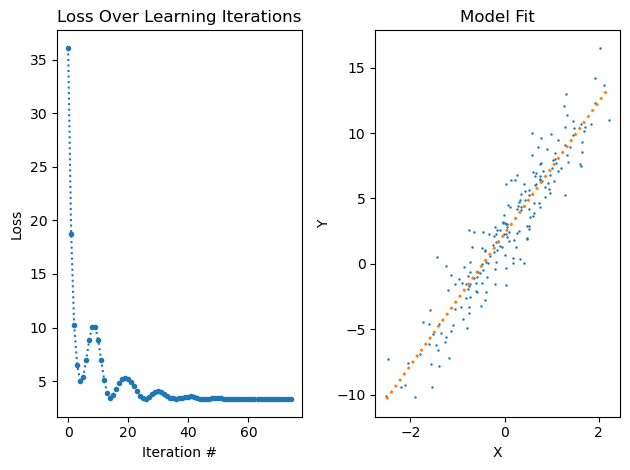

In [25]:
# Generate some Data
torch.manual_seed(42)
x = torch.randn(200, 1)
y_obs = (5 * x + 2) + 2 * torch.randn(200, 1)  # True Model: 5x + 2
y_obs[:20]

# Set up the model and training hyperparameters
model = nn.Sequential(nn.Linear(1, 1))
loss_function = nn.MSELoss()
optimizer = optim.Adam(params=model.parameters(), lr=1.5)   # UPDATE ME! (replace `SGD` with another from the table above)
num_iterations = 75 

# Train the Model
losses = [update_model(model, loss_function, optimizer, x, y_obs) for _ in range(num_iterations)]

# Make a Figure showing the losses and model fit
plt.subplot(1, 2, 1); plot_losses(losses);
plt.subplot(1, 2, 2); plot_1d_model_fit(model, x, y_obs);
plt.tight_layout();
dict(model.state_dict())

{'0.weight': tensor([[5.0358]]), '0.bias': tensor([2.2952])}

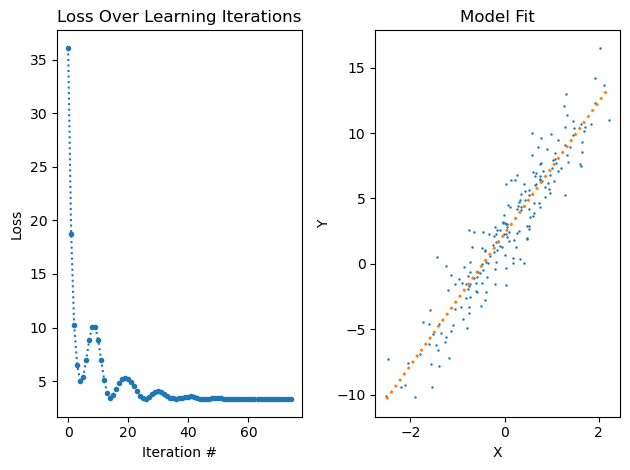

In [35]:
# Generate some Data
torch.manual_seed(42)
x = torch.randn(200, 1)
y_obs = (5 * x + 2) + 2 * torch.randn(200, 1)  # True Model: 5x + 2
y_obs[:20]

# Set up the model and training hyperparameters
model = nn.Sequential(nn.Linear(1, 1))
loss_function = nn.MSELoss()
optimizer = optim.Adam(params=model.parameters(), lr=1.5)   # UPDATE ME! (replace `SGD` with another from the table above)
num_iterations = 75 

# Train the Model
losses = [update_model(model, loss_function, optimizer, x, y_obs) for _ in range(num_iterations)]

# Make a Figure showing the losses and model fit
plt.subplot(1, 2, 1); plot_losses(losses);
plt.subplot(1, 2, 2); plot_1d_model_fit(model, x, y_obs);
plt.tight_layout();
dict(model.state_dict())

---

## Section 4: Verifying PyTorch: Implementing Mean Squared Error and Standard Gradient Descent

Are you wondering whether there is still some hidden magic that PyTorch is doing behind the scenes with `nn.MSELoss()` and `optim.SGD()`?  In this section, we'll re-implement Mean-Square-Error loss calculations and Standard Gradient Descent, in order to verify that PyTorch is indeed just doing these calculations.

The most challenging part of coding this is usually the calculating the derivatives on each parameter, but using PyTorch Tensors makes this easy because they have [AutoGrad](https://docs.pytorch.org/tutorials/beginner/blitz/autograd_tutorial.html); they will calculate the deriviates for us behind the scenes.  

That's what `loss.backward()` does: it calculates the derivatives of the parameters with respect to the loss and stores them on the parameter tensors themselves in their `.grad` attributes.  Then, the optimizer calculation can access those deriviates directly to decide how much to update the parameters.  To reset the gradients for the next pass, `zero_grad()` is called.  

Let's try it out!

### Exercises

Each of the exercises below build on the last one.  The `UPDATE ME!`-commented lines have directions on how to update the code to replace the PyTorch-supplied calculations with our own.

**Exercise**: **Mean-Squared Error Loss**: The new `update_model2()` function doesn't take a `loss_function` any more; it makes its own internally.  Replace the `nn.MSELoss()(y_pred, y_obs)` with the direct calculation of loss below, and confirm that the training goes exactly the same as with the PyTorch-supplied `nn.MSELoss()` function:

 $$  \mathrm{MSE}(\hat{y}, y) = \frac{1}{n} \sum_{i=1}^{n} \left(\hat{y}_i - y_i\right)^2 $$


{'0.weight': tensor([[4.8087]]), '0.bias': tensor([2.2150])}

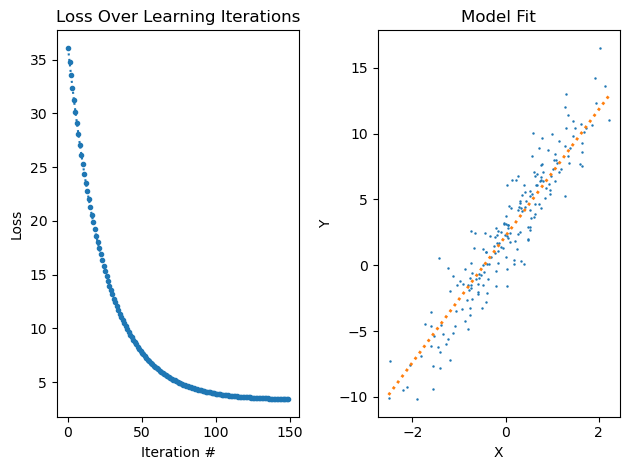

In [64]:
def update_model2(model, optimizer, x, y_obs) -> float:

    # Forward Pass
    optimizer.zero_grad()                  # Reset parameter gradients
    y_pred = model(x)                      # Make a Prediction
    loss = nn.MSELoss()(y_pred, y_obs)    # UPDATE ME!  Calculate mean squared error here: ((y_pred - y_obs) ** 2).mean()

    # Backward Pass
    loss.backward()   # Calculate the loss gradients and store them in each parameters' ".grad" attribute
    optimizer.step()  # Update the model's parameters, based on their stored gradients

    # record the loss, for plotting or logging
    return loss.item()  
    


# Generate some Data
torch.manual_seed(42)
x = torch.randn(200, 1)
y_obs = (5 * x + 2) + 2 * torch.randn(200, 1)  # True Model: 5x + 2
y_obs[:20]

# Set up the model and training hyperparameters
model = nn.Sequential(nn.Linear(1, 1)) 
optimizer = optim.SGD(params=model.parameters(), lr=.01)
num_iterations = 150  

# Train the Model
losses = [update_model2(model, optimizer, x, y_obs) for _ in range(num_iterations)]

# Make a Figure showing the losses and model fit
plt.subplot(1, 2, 1); plot_losses(losses);
plt.subplot(1, 2, 2); plot_1d_model_fit(model, x, y_obs);
plt.tight_layout();
dict(model.state_dict())

{'0.weight': tensor([[4.8087]]), '0.bias': tensor([2.2150])}

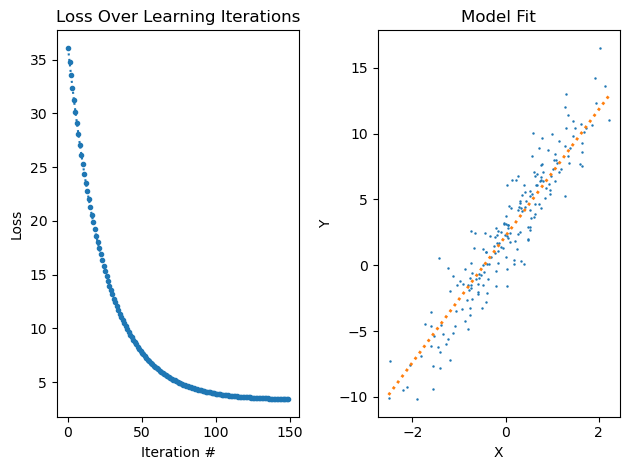

In [37]:
def update_model2(model, optimizer, x, y_obs) -> float:

    # Forward Pass
    optimizer.zero_grad()                  # Reset parameter gradients
    y_pred = model(x)                      # Make a Prediction
    loss = ((y_obs - y_pred) ** 2).mean()

    # Backward Pass
    loss.backward()   # Calculate the loss gradients and store them in each parameters' ".grad" attribute
    optimizer.step()  # Update the model's parameters, based on their stored gradients

    # record the loss, for plotting or logging
    return loss.item()  
    


# Generate some Data
torch.manual_seed(42)
x = torch.randn(200, 1)
y_obs = (5 * x + 2) + 2 * torch.randn(200, 1)  # True Model: 5x + 2
y_obs[:20]

# Set up the model and training hyperparameters
model = nn.Sequential(nn.Linear(1, 1)) 
optimizer = optim.SGD(params=model.parameters(), lr=.01)
num_iterations = 150  

# Train the Model
losses = [update_model2(model, optimizer, x, y_obs) for _ in range(num_iterations)]

# Make a Figure showing the losses and model fit
plt.subplot(1, 2, 1); plot_losses(losses);
plt.subplot(1, 2, 2); plot_1d_model_fit(model, x, y_obs);
plt.tight_layout();
dict(model.state_dict())

**Exercise**: **Standard Gradient Descent**: Let's build on the previous function by replacing the PyTorch-supplied `optim.SGD()` optimizer with our own direct calculation of the standard gradient descent equation:

$$
w_{i, t+1} = w_{i,t} - \eta \times \nabla L(w_{i,t})
$$

where $t$ is the current time step (epoch) in the training, $L$ is loss function to be minimized, and $\eta$ is the learning rate.

**Hint**: Useful code for updating parameters: `p[:] = p - lr * p.grad`


{'0.weight': tensor([[5.0821]]), '0.bias': tensor([2.2584])}

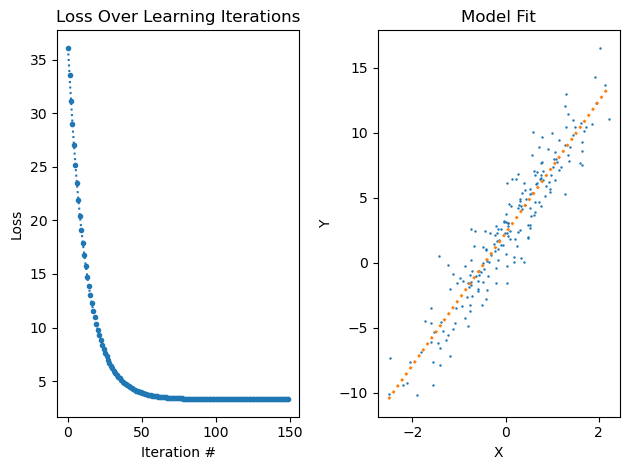

In [65]:
def update_model3(model, x, y_obs) -> float:

    # Forward Pass
    model.zero_grad()     # Reset parameter gradients 
    
    optimizer = optim.SGD(model.parameters(), lr=.01) # UPDATE ME: Delete this line
    
    y_pred = model(x)                      # Make a Prediction
    loss = ((y_obs - y_pred) ** 2).mean()  # Calculate Loss using the Mean-Squared Error method.

    # Backward Pass
    loss.backward()   # Calculate the loss gradients and store them in each parameters' ".grad" attribute
    optimizer.step()  # UPDATE ME: Delete this line

    lr = .01
    with torch.no_grad():
        for p in model.parameters():
            p[:] = p - lr * p.grad    # UPDATE ME: Do standard gradient descent: p[:] = p - lr * p.grad
    
    
    

    # record the loss, for plotting or logging
    return loss.item()  
    


# Generate some Data
torch.manual_seed(42)
x = torch.randn(200, 1)
y_obs = (5 * x + 2) + 2 * torch.randn(200, 1)  # True Model: 5x + 2
y_obs[:20]

# Set up the model and training hyperparameters
model = nn.Sequential(nn.Linear(1, 1)) 
optimizer = optim.SGD(params=model.parameters(), lr=.01)
num_iterations = 150  

# Train the Model
losses = [update_model3(model, x, y_obs) for _ in range(num_iterations)]

# Make a Figure showing the losses and model fit
plt.subplot(1, 2, 1); plot_losses(losses);
plt.subplot(1, 2, 2); plot_1d_model_fit(model, x, y_obs);
plt.tight_layout();
dict(model.state_dict())

In [ ]:
def update_model3(model, x, y_obs) -> float:

    # Forward Pass
    model.zero_grad()     # Reset parameter gradients 
    
    y_pred = model(x)                      # Make a Prediction
    loss = ((y_obs - y_pred) ** 2).mean()  # Calculate Loss using the Mean-Squared Error method.

    # Backward Pass
    loss.backward()   # Calculate the loss gradients and store them in each parameters' ".grad" attribute

    lr = .01
    with torch.no_grad():
        for p in model.parameters():
            p[:] = p - lr * p.grad

    # record the loss, for plotting or logging
    return loss.item()  
    


# Generate some Data
torch.manual_seed(42)
x = torch.randn(200, 1)
y_obs = (5 * x + 2) + 2 * torch.randn(200, 1)  # True Model: 5x + 2
y_obs[:20]

# Set up the model and training hyperparameters
model = nn.Sequential(nn.Linear(1, 1)) 
num_iterations = 150  

# Train the Model
losses = [update_model3(model, x, y_obs) for _ in range(num_iterations)]

# Make a Figure showing the losses and model fit
plt.subplot(1, 2, 1); plot_losses(losses);
plt.subplot(1, 2, 2); plot_1d_model_fit(model, x, y_obs);
plt.tight_layout();
dict(model.state_dict())

That's it, we've now replaced PyTorch's objects with our calculation, taking advantage of PyTorch's [AutoGrad](https://docs.pytorch.org/tutorials/beginner/blitz/autograd_tutorial.html) feature to make the code for our implementation simple.

Note: We don't advise doing this as a general practice, though. But it's very nice to have tested code from PyTorch supplied to us.